# How to train your DragoNN tutorial 5: 
## CNN Hyperparameter Tuning via Grid Search 
This tutorial is a supplement to the DragoNN manuscript and follows figure 6 in the manuscript. 

This tutorial will take 30 minutes - 1 hour if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Define default CNN architecture helper utilities</a></li> 
    <li><a href=#3>Data simulation and default CNN model performance</a></li>
    <ol>
        <li><a href=#3a>Simple Motif Detection: TAL1, CTCF, ZNF143, SIX5 </a></li>
        <li><a href=#3b>Motif Density Detection</a></li>
        <li><a href=#3c>Motif Density Localization</a></li>
        <li><a href=#3d>Multiple Motif Detection</a></li>
        <li><a href=#3e>Heterodimer Motif Grammar: SPI1_IRF</a></li>
    </ol>
    <li><a href=#4>Hyperparameter grid search</a></li>
    <ol>
    <li><a href=#4a>Training examples</a></li>
    <li><a href=#4b>Convolutional Filter Width </a></li>  
    <li><a href=#4c>Number of convolution filters</a></li>
    <li><a href=#4d>Max Pooling Width</a></li>
    </ol>
    <li><a href=#5>Conclusions</a></li>
</ol>

Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./primer_tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./primer_tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./primer_tutorial_images/inspecting_code.png)


In [80]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [81]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [82]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *


## Define basic CNN architecture helper utilities <a name='2'>
<a href=#outline>Home</a>


We start with a simple reference CNN architecture that contains a convolutional layer with 10 convolutional filters (size 15, stride 1) and ReLU activations, followed by max-pooling (size 35,stride 35), followed by a fully connected layer with a logistic output neuron for binary classification. Models are trained using the Adam optimizer with early stopping after 7 consecutive epochs without validation loss improvement. Performance (auROC) is recorded on an the independent test set.

We will initialize multiple models with this basic architecture, so we write helper functions to generate the architecture, perform training, print the loss curve, and print test set auROC. 

In [83]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


In [84]:
def build_default_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model 


In [85]:
from dragonn.callbacks import * 
def train_default_model(data,num_tasks,model_constructor=build_default_model):
    
    #Build the model 
    model=model_constructor(data.X_train.shape[1::],num_tasks)
    
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),
                                 validation_data=(data.X_valid,data.y_valid))
    #Train the Model
    history=model.fit(x=data.X_train,y=data.y_train,
                      batch_size=128,
                      epochs=150,
                      verbose=0,
                      callbacks=[EarlyStopping(patience=7),
                                 History(),
                                 metrics_callback],
                      validation_data=(data.X_valid,data.y_valid))
    #Plot the learning curve
    plot_learning_curve(history)
    
    #Print model performance on held-out test set
    print("Test Set Performance:")
    test_predictions=model.predict(data.X_test)
    print(ClassificationResult(data.y_test,test_predictions))

    #return the trained model and history 
    return model,history


## Data simulation and basic architecture performance <a name='2'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [86]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


We design four single-task binary classification tasks using DNA sequences that simulate different
properties of regulatory DNA sequences: single motif, homotypic motif clusters, heterotypic motif
clusters, and heterodimer motif grammars with spatial constraints. We further design a multitask
classification simulation to jointly detect motif instances of 3 distinct TFs (corresponding to 3 binary
classification tasks, one per TF). In each simulation, we embed motif instances with the relevant
constraints in random sequences (G/C frequency = 0.4). We hold out 20% of sequences for a test
set, 16% for a validation set, and use the remaining sequences for training. Motif instances are
reverse complemented with 0.5 probability before they are embedded in the background sequence.

We train models with the default architecture for these 4 individual TF simulations and evaluate the models' performance: 

### Simple Motif Detection: 

TAL1_Known4: 
![play button](./primer_tutorial_images/TAL1_known4.png)

Training Data:
Loss: 0.6934	Balanced Accuracy: 52.26%	 auROC: 0.527	 auPRC: 0.521
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.7011	Balanced Accuracy: 47.52%	 auROC: 0.479	 auPRC: 0.491
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6892	Balanced Accuracy: 53.26%	 auROC: 0.551	 auPRC: 0.544
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.7002	Balanced Accuracy: 48.64%	 auROC: 0.485	 auPRC: 0.498
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6856	Balanced Accuracy: 54.58%	 auROC: 0.573	 auPRC: 0.565
	Recall at 5%|10%|20% FDR: 0.2%|0.3%|0.4%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.6993	Balanced Accuracy: 49.65%	 auROC: 0.493	 auPRC: 0.502
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 158

Training Data:
Loss: 0.4744	Balanced Accuracy: 79.27%	 auROC: 0.872	 auPRC: 0.861
	Recall at 5%|10%|20% FDR: 10.4%|44.9%|79.3%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.5019	Balanced Accuracy: 77.79%	 auROC: 0.850	 auPRC: 0.832
	Recall at 5%|10%|20% FDR: 1.9%|18.0%|75.1%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.4611	Balanced Accuracy: 80.34%	 auROC: 0.883	 auPRC: 0.872
	Recall at 5%|10%|20% FDR: 13.1%|51.2%|82.3%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.4878	Balanced Accuracy: 78.80%	 auROC: 0.863	 auPRC: 0.845
	Recall at 5%|10%|20% FDR: 2.6%|31.2%|78.8%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.4451	Balanced Accuracy: 81.80%	 auROC: 0.892	 auPRC: 0.881
	Recall at 5%|10%|20% FDR: 15.5%|56.2%|85.8%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.4707	Balanced Accuracy: 80.91%	 auROC: 0.874	 auPRC: 0.855
	Recall at 5%|10%|20% FDR: 2.7%|36.5%|83.1%	 Num Positives: 1617	 Num

Training Data:
Loss: 0.3104	Balanced Accuracy: 89.57%	 auROC: 0.942	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 60.4%|89.0%|94.5%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3373	Balanced Accuracy: 87.51%	 auROC: 0.929	 auPRC: 0.922
	Recall at 5%|10%|20% FDR: 28.9%|82.3%|95.4%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.3084	Balanced Accuracy: 89.62%	 auROC: 0.942	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 60.5%|89.2%|94.4%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3357	Balanced Accuracy: 87.47%	 auROC: 0.929	 auPRC: 0.921
	Recall at 5%|10%|20% FDR: 29.0%|82.2%|95.4%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.3062	Balanced Accuracy: 89.72%	 auROC: 0.942	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 60.1%|89.4%|94.5%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3341	Balanced Accuracy: 87.87%	 auROC: 0.929	 auPRC: 0.922
	Recall at 5%|10%|20% FDR: 29.1%|82.1%|95.4%	 Num Positives: 1617	 

Training Data:
Loss: 0.2859	Balanced Accuracy: 90.61%	 auROC: 0.948	 auPRC: 0.943
	Recall at 5%|10%|20% FDR: 67.5%|91.5%|95.1%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3224	Balanced Accuracy: 89.40%	 auROC: 0.933	 auPRC: 0.927
	Recall at 5%|10%|20% FDR: 37.3%|86.8%|95.3%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.2855	Balanced Accuracy: 90.55%	 auROC: 0.949	 auPRC: 0.943
	Recall at 5%|10%|20% FDR: 67.7%|91.5%|95.2%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3225	Balanced Accuracy: 89.19%	 auROC: 0.933	 auPRC: 0.928
	Recall at 5%|10%|20% FDR: 37.7%|87.1%|95.2%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.2850	Balanced Accuracy: 90.59%	 auROC: 0.948	 auPRC: 0.943
	Recall at 5%|10%|20% FDR: 68.0%|91.6%|95.2%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3220	Balanced Accuracy: 89.40%	 auROC: 0.933	 auPRC: 0.927
	Recall at 5%|10%|20% FDR: 36.8%|86.8%|95.2%	 Num Positives: 1617	 

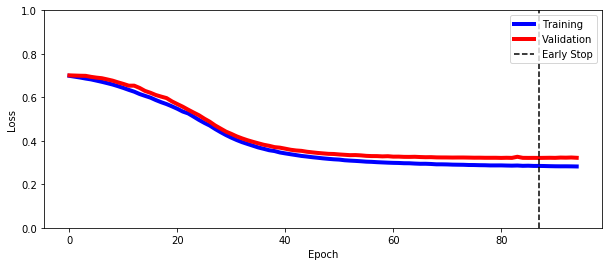

Test Set Performance:
Loss: nan	Balanced Accuracy: 90.04%	 auROC: 0.936	 auPRC: 0.928
	Recall at 5%|10%|20% FDR: 56.9%|90.7%|94.7%	 Num Positives: 1982	 Num Negatives: 2018


In [67]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
tal1_default_model,tal1_default_history=train_default_model(tal1_data,1)

CTCF_Known1: 
![play button](./primer_tutorial_images/CTCF_known1.png)

Training Data:
Loss: 0.6943	Balanced Accuracy: 51.84%	 auROC: 0.528	 auPRC: 0.526
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.6970	Balanced Accuracy: 50.88%	 auROC: 0.505	 auPRC: 0.491
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1569	 Num Negatives: 1631
Training Data:
Loss: 0.6870	Balanced Accuracy: 54.62%	 auROC: 0.565	 auPRC: 0.559
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.6924	Balanced Accuracy: 52.69%	 auROC: 0.532	 auPRC: 0.514
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1569	 Num Negatives: 1631
Training Data:
Loss: 0.6780	Balanced Accuracy: 58.04%	 auROC: 0.613	 auPRC: 0.606
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.6849	Balanced Accuracy: 55.55%	 auROC: 0.574	 auPRC: 0.555
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|1.2%	 Num Positives: 1569	 Num Negatives: 163

Training Data:
Loss: 0.3551	Balanced Accuracy: 86.31%	 auROC: 0.930	 auPRC: 0.935
	Recall at 5%|10%|20% FDR: 66.9%|81.7%|91.4%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.3828	Balanced Accuracy: 85.02%	 auROC: 0.913	 auPRC: 0.919
	Recall at 5%|10%|20% FDR: 52.6%|76.0%|88.3%	 Num Positives: 1569	 Num Negatives: 1631
Training Data:
Loss: 0.3486	Balanced Accuracy: 86.46%	 auROC: 0.932	 auPRC: 0.938
	Recall at 5%|10%|20% FDR: 68.8%|82.2%|91.7%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.3739	Balanced Accuracy: 85.36%	 auROC: 0.915	 auPRC: 0.922
	Recall at 5%|10%|20% FDR: 56.3%|76.9%|89.0%	 Num Positives: 1569	 Num Negatives: 1631
Training Data:
Loss: 0.3428	Balanced Accuracy: 86.74%	 auROC: 0.933	 auPRC: 0.939
	Recall at 5%|10%|20% FDR: 69.7%|82.4%|91.8%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.3693	Balanced Accuracy: 85.63%	 auROC: 0.917	 auPRC: 0.924
	Recall at 5%|10%|20% FDR: 59.4%|78.3%|89.1%	 Num Positives: 1569	 

Training Data:
Loss: 0.2949	Balanced Accuracy: 88.45%	 auROC: 0.945	 auPRC: 0.953
	Recall at 5%|10%|20% FDR: 78.4%|86.5%|93.0%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.3333	Balanced Accuracy: 86.84%	 auROC: 0.924	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 71.9%|82.0%|89.7%	 Num Positives: 1569	 Num Negatives: 1631
Training Data:
Loss: 0.2945	Balanced Accuracy: 88.40%	 auROC: 0.945	 auPRC: 0.953
	Recall at 5%|10%|20% FDR: 78.3%|86.5%|92.9%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.3342	Balanced Accuracy: 86.94%	 auROC: 0.924	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 71.7%|82.0%|89.7%	 Num Positives: 1569	 Num Negatives: 1631
Training Data:
Loss: 0.2951	Balanced Accuracy: 88.38%	 auROC: 0.945	 auPRC: 0.953
	Recall at 5%|10%|20% FDR: 78.1%|86.5%|92.9%	 Num Positives: 6439	 Num Negatives: 6361
Validation Data:
Loss: 0.3367	Balanced Accuracy: 86.80%	 auROC: 0.924	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 71.4%|81.8%|89.7%	 Num Positives: 1569	 

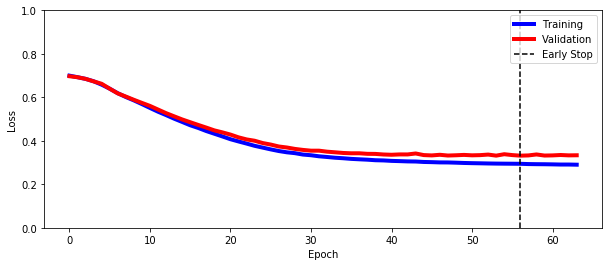

Test Set Performance:
Loss: 0.3203	Balanced Accuracy: 86.99%	 auROC: 0.928	 auPRC: 0.943
	Recall at 5%|10%|20% FDR: 74.8%|83.2%|90.4%	 Num Positives: 1992	 Num Negatives: 2008


In [68]:
#Define simulation parameters 
ctcf_parameters = {
    "motif_name": "CTCF_known1",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
ctcf_data = get_simulation_data("simulate_single_motif_detection",
                                      ctcf_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
ctcf_default_model,ctcf_default_history=train_default_model(ctcf_data,1)

ZNF143_known2: 
![play button](./primer_tutorial_images/ZNF143_known2.png)

Training Data:
Loss: 0.6934	Balanced Accuracy: 51.76%	 auROC: 0.523	 auPRC: 0.525
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.6957	Balanced Accuracy: 50.48%	 auROC: 0.508	 auPRC: 0.503
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1584	 Num Negatives: 1616
Training Data:
Loss: 0.6914	Balanced Accuracy: 51.93%	 auROC: 0.544	 auPRC: 0.543
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.6969	Balanced Accuracy: 50.26%	 auROC: 0.513	 auPRC: 0.507
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1584	 Num Negatives: 1616
Training Data:
Loss: 0.6872	Balanced Accuracy: 54.07%	 auROC: 0.562	 auPRC: 0.560
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.3%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.6949	Balanced Accuracy: 50.58%	 auROC: 0.512	 auPRC: 0.508
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1584	 Num Negatives: 161

Training Data:
Loss: 0.3146	Balanced Accuracy: 89.87%	 auROC: 0.951	 auPRC: 0.958
	Recall at 5%|10%|20% FDR: 83.7%|89.9%|94.2%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.3174	Balanced Accuracy: 89.70%	 auROC: 0.952	 auPRC: 0.954
	Recall at 5%|10%|20% FDR: 80.1%|89.8%|94.3%	 Num Positives: 1584	 Num Negatives: 1616
Training Data:
Loss: 0.3036	Balanced Accuracy: 90.26%	 auROC: 0.952	 auPRC: 0.960
	Recall at 5%|10%|20% FDR: 84.6%|90.3%|94.5%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.3056	Balanced Accuracy: 90.29%	 auROC: 0.954	 auPRC: 0.957
	Recall at 5%|10%|20% FDR: 82.1%|90.7%|94.3%	 Num Positives: 1584	 Num Negatives: 1616
Training Data:
Loss: 0.2939	Balanced Accuracy: 90.78%	 auROC: 0.954	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 85.5%|90.6%|94.6%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2943	Balanced Accuracy: 90.52%	 auROC: 0.956	 auPRC: 0.959
	Recall at 5%|10%|20% FDR: 83.8%|91.1%|94.6%	 Num Positives: 1584	 

Training Data:
Loss: 0.2201	Balanced Accuracy: 92.39%	 auROC: 0.966	 auPRC: 0.974
	Recall at 5%|10%|20% FDR: 89.8%|92.9%|95.2%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2328	Balanced Accuracy: 91.34%	 auROC: 0.963	 auPRC: 0.970
	Recall at 5%|10%|20% FDR: 89.8%|92.2%|95.3%	 Num Positives: 1584	 Num Negatives: 1616
Training Data:
Loss: 0.2164	Balanced Accuracy: 92.56%	 auROC: 0.966	 auPRC: 0.974
	Recall at 5%|10%|20% FDR: 89.9%|93.0%|95.2%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2290	Balanced Accuracy: 91.93%	 auROC: 0.963	 auPRC: 0.970
	Recall at 5%|10%|20% FDR: 90.1%|92.2%|95.1%	 Num Positives: 1584	 Num Negatives: 1616
Training Data:
Loss: 0.2158	Balanced Accuracy: 92.49%	 auROC: 0.967	 auPRC: 0.974
	Recall at 5%|10%|20% FDR: 89.8%|93.0%|95.2%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2295	Balanced Accuracy: 91.96%	 auROC: 0.963	 auPRC: 0.970
	Recall at 5%|10%|20% FDR: 90.0%|92.1%|95.2%	 Num Positives: 1584	 

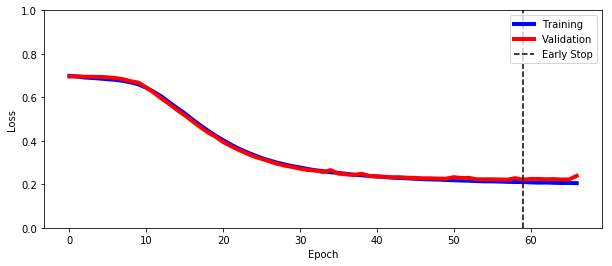

Test Set Performance:
Loss: 0.2429	Balanced Accuracy: 91.55%	 auROC: 0.958	 auPRC: 0.970
	Recall at 5%|10%|20% FDR: 89.0%|92.6%|94.6%	 Num Positives: 1990	 Num Negatives: 2010


In [69]:
#Define simulation parameters 
znf143_parameters={
    "motif_name": "ZNF143_known2",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data 
znf143_data=get_simulation_data("simulate_single_motif_detection",
                               znf143_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
znf143_default_model,znf143_default_history=train_default_model(znf143_data,1)

SIX5_known1:  
![play button](./primer_tutorial_images/SIX5_known1.png) 

Training Data:
Loss: 0.6944	Balanced Accuracy: 51.13%	 auROC: 0.520	 auPRC: 0.518
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.7003	Balanced Accuracy: 49.17%	 auROC: 0.489	 auPRC: 0.486
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1587	 Num Negatives: 1613
Training Data:
Loss: 0.6920	Balanced Accuracy: 52.74%	 auROC: 0.537	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.2%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.6995	Balanced Accuracy: 50.17%	 auROC: 0.492	 auPRC: 0.490
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1587	 Num Negatives: 1613
Training Data:
Loss: 0.6891	Balanced Accuracy: 54.02%	 auROC: 0.555	 auPRC: 0.548
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.6982	Balanced Accuracy: 50.13%	 auROC: 0.497	 auPRC: 0.496
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1587	 Num Negatives: 161

Training Data:
Loss: 0.5456	Balanced Accuracy: 73.94%	 auROC: 0.817	 auPRC: 0.804
	Recall at 5%|10%|20% FDR: 0.0%|21.6%|59.9%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.5828	Balanced Accuracy: 70.43%	 auROC: 0.767	 auPRC: 0.753
	Recall at 5%|10%|20% FDR: 2.3%|4.4%|35.7%	 Num Positives: 1587	 Num Negatives: 1613
Training Data:
Loss: 0.5409	Balanced Accuracy: 73.95%	 auROC: 0.822	 auPRC: 0.809
	Recall at 5%|10%|20% FDR: 0.0%|23.9%|61.3%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.5771	Balanced Accuracy: 70.48%	 auROC: 0.774	 auPRC: 0.759
	Recall at 5%|10%|20% FDR: 1.7%|4.5%|38.9%	 Num Positives: 1587	 Num Negatives: 1613
Training Data:
Loss: 0.5385	Balanced Accuracy: 74.62%	 auROC: 0.825	 auPRC: 0.813
	Recall at 5%|10%|20% FDR: 0.0%|24.4%|62.6%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.5777	Balanced Accuracy: 71.06%	 auROC: 0.779	 auPRC: 0.764
	Recall at 5%|10%|20% FDR: 3.0%|4.3%|40.3%	 Num Positives: 1587	 Num Negat

Training Data:
Loss: 0.4451	Balanced Accuracy: 80.98%	 auROC: 0.879	 auPRC: 0.873
	Recall at 5%|10%|20% FDR: 15.7%|58.7%|82.3%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.5000	Balanced Accuracy: 78.21%	 auROC: 0.841	 auPRC: 0.826
	Recall at 5%|10%|20% FDR: 0.0%|22.4%|74.7%	 Num Positives: 1587	 Num Negatives: 1613
Training Data:
Loss: 0.4431	Balanced Accuracy: 81.08%	 auROC: 0.880	 auPRC: 0.874
	Recall at 5%|10%|20% FDR: 15.9%|59.0%|82.4%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.4985	Balanced Accuracy: 78.49%	 auROC: 0.841	 auPRC: 0.827
	Recall at 5%|10%|20% FDR: 0.0%|24.8%|75.6%	 Num Positives: 1587	 Num Negatives: 1613
Training Data:
Loss: 0.4416	Balanced Accuracy: 81.16%	 auROC: 0.880	 auPRC: 0.874
	Recall at 5%|10%|20% FDR: 16.4%|59.6%|82.5%	 Num Positives: 6397	 Num Negatives: 6403
Validation Data:
Loss: 0.4978	Balanced Accuracy: 78.58%	 auROC: 0.842	 auPRC: 0.827
	Recall at 5%|10%|20% FDR: 0.0%|25.2%|75.7%	 Num Positives: 1587	 Num

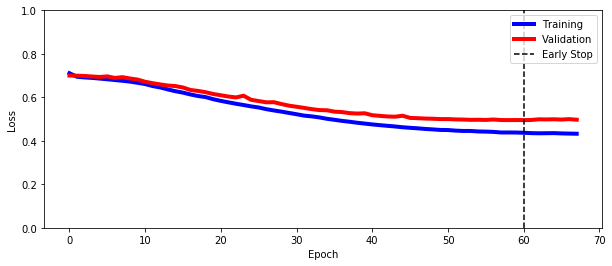

Test Set Performance:
Loss: 0.4863	Balanced Accuracy: 79.18%	 auROC: 0.846	 auPRC: 0.850
	Recall at 5%|10%|20% FDR: 7.6%|42.5%|77.2%	 Num Positives: 2016	 Num Negatives: 1984


In [70]:
#Define simulation parameters 
six5_parameters={
    "motif_name": "SIX5_known1",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
six5_data=get_simulation_data("simulate_single_motif_detection",
                               six5_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
six5_default_model,six5_default_history=train_default_model(six5_data,1)

### Motif Density Detection 

In this binary simulation task, we simulate 10K 500 bp random sequences with 0-2 instances of a TAL1 motif embedded at any random position and
10K 500 bp random sequences with 3-5 instances of the motif embedded at any random position. To solve this simulation, the model needs to learn the differences in motif counts.

In [71]:
print_simulation_info("simulate_motif_counting")



    Generates data for motif counting task.

    Parameters
    ----------
    motif_name : str
    seq_length : int
    pos_counts : list
        (min_counts, max_counts) for positive set.
    neg_counts : list
        (min_counts, max_counts) for negative set.
    num_pos : int
    num_neg : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darray
        Contains labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


Training Data:
Loss: 0.6914	Balanced Accuracy: 52.92%	 auROC: 0.538	 auPRC: 0.529
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.6978	Balanced Accuracy: 50.23%	 auROC: 0.503	 auPRC: 0.508
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.6755	Balanced Accuracy: 58.40%	 auROC: 0.620	 auPRC: 0.613
	Recall at 5%|10%|20% FDR: 0.4%|0.6%|3.1%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.6837	Balanced Accuracy: 55.07%	 auROC: 0.579	 auPRC: 0.583
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.5%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.6333	Balanced Accuracy: 70.24%	 auROC: 0.768	 auPRC: 0.768
	Recall at 5%|10%|20% FDR: 3.0%|19.0%|43.2%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.6433	Balanced Accuracy: 66.64%	 auROC: 0.733	 auPRC: 0.747
	Recall at 5%|10%|20% FDR: 8.9%|16.3%|36.9%	 Num Positives: 1605	 Num Negatives:

Training Data:
Loss: 0.2086	Balanced Accuracy: 91.70%	 auROC: 0.975	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 87.1%|92.7%|97.4%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.2241	Balanced Accuracy: 90.97%	 auROC: 0.971	 auPRC: 0.972
	Recall at 5%|10%|20% FDR: 82.6%|92.6%|97.1%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.2061	Balanced Accuracy: 91.76%	 auROC: 0.976	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 87.2%|92.9%|97.5%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.2220	Balanced Accuracy: 90.88%	 auROC: 0.971	 auPRC: 0.972
	Recall at 5%|10%|20% FDR: 83.6%|92.4%|97.2%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.2118	Balanced Accuracy: 91.60%	 auROC: 0.976	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 87.4%|93.0%|97.5%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.2288	Balanced Accuracy: 90.35%	 auROC: 0.971	 auPRC: 0.972
	Recall at 5%|10%|20% FDR: 83.4%|92.5%|97.1%	 Num Positives: 1605	 

Training Data:
Loss: 0.1863	Balanced Accuracy: 92.23%	 auROC: 0.980	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 89.6%|94.5%|98.1%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.2129	Balanced Accuracy: 91.15%	 auROC: 0.973	 auPRC: 0.974
	Recall at 5%|10%|20% FDR: 84.9%|92.7%|97.4%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.1818	Balanced Accuracy: 92.60%	 auROC: 0.980	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 89.7%|94.6%|98.1%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.2094	Balanced Accuracy: 91.62%	 auROC: 0.973	 auPRC: 0.974
	Recall at 5%|10%|20% FDR: 85.1%|92.8%|97.4%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.1800	Balanced Accuracy: 92.63%	 auROC: 0.981	 auPRC: 0.982
	Recall at 5%|10%|20% FDR: 90.0%|94.8%|98.1%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.2085	Balanced Accuracy: 92.03%	 auROC: 0.973	 auPRC: 0.975
	Recall at 5%|10%|20% FDR: 85.7%|92.7%|97.4%	 Num Positives: 1605	 

Training Data:
Loss: 0.1488	Balanced Accuracy: 94.17%	 auROC: 0.987	 auPRC: 0.988
	Recall at 5%|10%|20% FDR: 93.4%|96.2%|98.9%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1862	Balanced Accuracy: 92.13%	 auROC: 0.979	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 90.0%|93.4%|97.9%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.1493	Balanced Accuracy: 93.96%	 auROC: 0.987	 auPRC: 0.988
	Recall at 5%|10%|20% FDR: 93.5%|96.2%|98.9%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1871	Balanced Accuracy: 92.06%	 auROC: 0.979	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 90.1%|93.5%|97.9%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.1468	Balanced Accuracy: 94.40%	 auROC: 0.987	 auPRC: 0.988
	Recall at 5%|10%|20% FDR: 93.6%|96.3%|99.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1849	Balanced Accuracy: 92.44%	 auROC: 0.979	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 90.2%|93.5%|98.0%	 Num Positives: 1605	 

Training Data:
Loss: 0.1332	Balanced Accuracy: 94.83%	 auROC: 0.989	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 94.5%|96.8%|99.2%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1796	Balanced Accuracy: 93.32%	 auROC: 0.980	 auPRC: 0.982
	Recall at 5%|10%|20% FDR: 90.9%|94.1%|97.8%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.1320	Balanced Accuracy: 94.84%	 auROC: 0.989	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 94.5%|96.9%|99.2%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1793	Balanced Accuracy: 93.06%	 auROC: 0.980	 auPRC: 0.982
	Recall at 5%|10%|20% FDR: 91.1%|94.1%|97.6%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: 0.1317	Balanced Accuracy: 94.82%	 auROC: 0.989	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 94.5%|96.8%|99.2%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1792	Balanced Accuracy: 92.72%	 auROC: 0.980	 auPRC: 0.983
	Recall at 5%|10%|20% FDR: 91.2%|94.1%|97.8%	 Num Positives: 1605	 

Training Data:
Loss: nan	Balanced Accuracy: 95.17%	 auROC: 0.991	 auPRC: 0.992
	Recall at 5%|10%|20% FDR: 95.0%|97.4%|99.3%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1754	Balanced Accuracy: 93.53%	 auROC: 0.981	 auPRC: 0.983
	Recall at 5%|10%|20% FDR: 92.1%|94.2%|97.9%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: nan	Balanced Accuracy: 95.21%	 auROC: 0.991	 auPRC: 0.992
	Recall at 5%|10%|20% FDR: 95.1%|97.4%|99.3%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1753	Balanced Accuracy: 93.56%	 auROC: 0.981	 auPRC: 0.983
	Recall at 5%|10%|20% FDR: 91.9%|94.5%|97.9%	 Num Positives: 1605	 Num Negatives: 1595
Training Data:
Loss: nan	Balanced Accuracy: 95.10%	 auROC: 0.991	 auPRC: 0.992
	Recall at 5%|10%|20% FDR: 95.1%|97.5%|99.3%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1780	Balanced Accuracy: 92.87%	 auROC: 0.981	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 92.5%|94.4%|97.9%	 Num Positives: 1605	 Num Negat

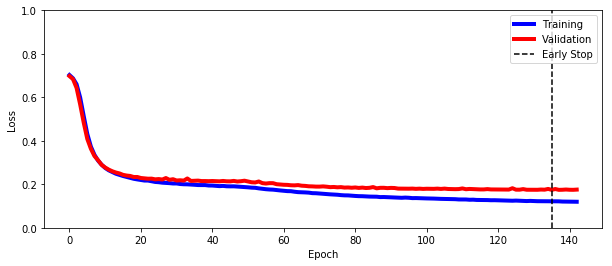

Test Set Performance:
Loss: nan	Balanced Accuracy: 93.09%	 auROC: 0.982	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 91.9%|94.1%|98.3%	 Num Positives: 2037	 Num Negatives: 1963


In [72]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_detection_default_model,density_detection_default_history=train_default_model(density_detection_data,1)

### Motif Density Localization 

In this binary simulation task, we simulate 20K random sequences of length 1 Kbp with 2-4 embedded instances of the TAL1 motif. In the positive set of 10K sequences, the motif instances are embedded in the central 150bp. The negative set of 10K sequences, contain embedded motif instances at any random position. To solve this simulation, the model needs to learn localization differences of the motif instances.

In [73]:
print_simulation_info("simulate_motif_density_localization")



    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Training Data:
Loss: 0.6741	Balanced Accuracy: 57.90%	 auROC: 0.647	 auPRC: 0.637
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.6812	Balanced Accuracy: 56.82%	 auROC: 0.630	 auPRC: 0.601
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|2.2%	 Num Positives: 1527	 Num Negatives: 1673
Training Data:
Loss: 0.5601	Balanced Accuracy: 83.01%	 auROC: 0.911	 auPRC: 0.906
	Recall at 5%|10%|20% FDR: 39.8%|66.9%|87.6%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.5690	Balanced Accuracy: 81.48%	 auROC: 0.897	 auPRC: 0.886
	Recall at 5%|10%|20% FDR: 36.9%|56.8%|81.5%	 Num Positives: 1527	 Num Negatives: 1673
Training Data:
Loss: 0.3839	Balanced Accuracy: 89.88%	 auROC: 0.964	 auPRC: 0.961
	Recall at 5%|10%|20% FDR: 76.9%|90.1%|97.8%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.3981	Balanced Accuracy: 88.59%	 auROC: 0.958	 auPRC: 0.952
	Recall at 5%|10%|20% FDR: 71.1%|86.3%|95.5%	 Num Positives: 1527	 Num Ne

Training Data:
Loss: 0.1345	Balanced Accuracy: 95.11%	 auROC: 0.989	 auPRC: 0.988
	Recall at 5%|10%|20% FDR: 95.3%|98.9%|99.9%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.1727	Balanced Accuracy: 93.29%	 auROC: 0.982	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 88.5%|95.2%|99.2%	 Num Positives: 1527	 Num Negatives: 1673
Training Data:
Loss: 0.1314	Balanced Accuracy: 95.30%	 auROC: 0.990	 auPRC: 0.988
	Recall at 5%|10%|20% FDR: 95.5%|99.0%|99.9%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.1704	Balanced Accuracy: 93.31%	 auROC: 0.982	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 88.5%|95.8%|99.2%	 Num Positives: 1527	 Num Negatives: 1673
Training Data:
Loss: 0.1282	Balanced Accuracy: 95.44%	 auROC: 0.990	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 95.7%|99.1%|99.9%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.1677	Balanced Accuracy: 93.64%	 auROC: 0.983	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 88.8%|95.7%|99.2%	 Num Positives: 1527	 

Training Data:
Loss: 0.0851	Balanced Accuracy: 97.01%	 auROC: 0.996	 auPRC: 0.995
	Recall at 5%|10%|20% FDR: 99.0%|99.9%|100.0%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.1378	Balanced Accuracy: 95.20%	 auROC: 0.988	 auPRC: 0.986
	Recall at 5%|10%|20% FDR: 94.0%|98.3%|99.8%	 Num Positives: 1527	 Num Negatives: 1673
Training Data:
Loss: 0.0815	Balanced Accuracy: 97.18%	 auROC: 0.996	 auPRC: 0.995
	Recall at 5%|10%|20% FDR: 99.1%|99.9%|100.0%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.1343	Balanced Accuracy: 95.08%	 auROC: 0.988	 auPRC: 0.986
	Recall at 5%|10%|20% FDR: 94.1%|98.2%|99.8%	 Num Positives: 1527	 Num Negatives: 1673
Training Data:
Loss: 0.0800	Balanced Accuracy: 97.26%	 auROC: 0.996	 auPRC: 0.995
	Recall at 5%|10%|20% FDR: 99.1%|99.9%|100.0%	 Num Positives: 6458	 Num Negatives: 6342
Validation Data:
Loss: 0.1332	Balanced Accuracy: 95.14%	 auROC: 0.988	 auPRC: 0.986
	Recall at 5%|10%|20% FDR: 94.2%|98.2%|99.8%	 Num Positives: 152

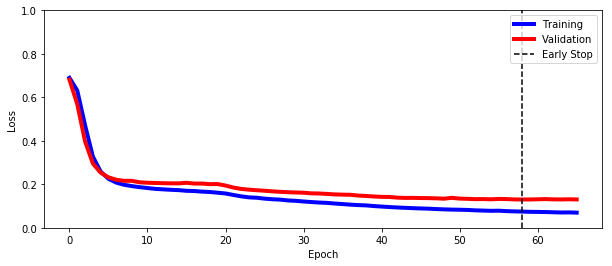

Test Set Performance:
Loss: 0.1280	Balanced Accuracy: 95.65%	 auROC: 0.989	 auPRC: 0.987
	Recall at 5%|10%|20% FDR: 96.4%|98.7%|100.0%	 Num Positives: 2015	 Num Negatives: 1985


In [74]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_localization_default_model,density_localization_default_history=train_default_model(density_localization_data,1)

### Multiple Motif Detection 

In this simulation of multiple co-binding TFs, we simulate 20K 500 bp random sequences. For each sequence, we independently embed 0 or 1 instance of motifs corresponding to 3 TFs: CTCF, ZNF143, and SIX5 (See SM). Each sequence has binary labels for 3 tasks corresponding to the presence/absence of a motif instance of each of the three TFs. We train a multitask CNN such as that the last layer of the model now has three output logistic neurons corresponding to the three separate tasks. To solve this simulation, the model needs to detect all three motifs while sharing parameters.

In [75]:
print_simulation_info("simulate_multi_motif_embedding")



    Generates data for multi motif recognition task.

    Parameters
    ----------
    motif_names : list
        List of strings.
    seq_length : int
    min_num_motifs : int
    max_num_motifs : int
    num_seqs : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : ndarray
        Contains labels for each motif.
    embedding_arr: 1darray
        Array of embedding objects.
    


Training Data:
Task 0: Loss: 0.4469	Balanced Accuracy: 50.00%	 auROC: 0.530	 auPRC: 0.185
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.4531	Balanced Accuracy: 50.00%	 auROC: 0.508	 auPRC: 0.170
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.4489	Balanced Accuracy: 50.00%	 auROC: 0.506	 auPRC: 0.167
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.4729	Balanced Accuracy: 50.00%	 auROC: 0.495	 auPRC: 0.176
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.4479	Balanced Accuracy: 50.00%	 auROC: 0.491	 auPRC: 0.167
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.4458	Balanced Accuracy: 50.00%	 auROC: 0.524	 auPRC: 0.171
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Training Data:

Training Data:
Task 0: Loss: 0.4269	Balanced Accuracy: 50.00%	 auROC: 0.682	 auPRC: 0.319
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.5%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.4460	Balanced Accuracy: 50.00%	 auROC: 0.578	 auPRC: 0.206
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.4425	Balanced Accuracy: 50.00%	 auROC: 0.570	 auPRC: 0.203
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.4569	Balanced Accuracy: 50.00%	 auROC: 0.628	 auPRC: 0.267
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.4470	Balanced Accuracy: 50.00%	 auROC: 0.509	 auPRC: 0.163
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.4447	Balanced Accuracy: 50.00%	 auROC: 0.531	 auPRC: 0.177
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Training Data:

Training Data:
Task 0: Loss: 0.3125	Balanced Accuracy: 63.91%	 auROC: 0.892	 auPRC: 0.686
	Recall at 5%|10%|20% FDR: 2.5%|13.1%|40.4%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.4405	Balanced Accuracy: 50.00%	 auROC: 0.632	 auPRC: 0.248
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.4393	Balanced Accuracy: 50.00%	 auROC: 0.616	 auPRC: 0.225
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.3351	Balanced Accuracy: 61.86%	 auROC: 0.882	 auPRC: 0.663
	Recall at 5%|10%|20% FDR: 4.0%|5.6%|31.8%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.4434	Balanced Accuracy: 50.00%	 auROC: 0.564	 auPRC: 0.201
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.4438	Balanced Accuracy: 50.00%	 auROC: 0.569	 auPRC: 0.188
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Training Da

Training Data:
Task 0: Loss: 0.2202	Balanced Accuracy: 79.63%	 auROC: 0.936	 auPRC: 0.832
	Recall at 5%|10%|20% FDR: 28.2%|56.3%|74.8%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.4193	Balanced Accuracy: 50.00%	 auROC: 0.709	 auPRC: 0.331
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.4292	Balanced Accuracy: 50.00%	 auROC: 0.640	 auPRC: 0.238
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.2356	Balanced Accuracy: 79.44%	 auROC: 0.935	 auPRC: 0.826
	Recall at 5%|10%|20% FDR: 38.0%|54.8%|72.1%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.4225	Balanced Accuracy: 50.00%	 auROC: 0.667	 auPRC: 0.271
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.4365	Balanced Accuracy: 50.00%	 auROC: 0.593	 auPRC: 0.197
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 522	 Num Negatives: 2678
Training

Training Data:
Task 0: Loss: 0.1848	Balanced Accuracy: 85.45%	 auROC: 0.946	 auPRC: 0.874
	Recall at 5%|10%|20% FDR: 54.2%|69.8%|82.8%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.3673	Balanced Accuracy: 52.20%	 auROC: 0.823	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 1.6%|2.7%|7.7%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.4202	Balanced Accuracy: 50.00%	 auROC: 0.671	 auPRC: 0.269
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1984	Balanced Accuracy: 84.82%	 auROC: 0.945	 auPRC: 0.868
	Recall at 5%|10%|20% FDR: 58.2%|69.4%|80.0%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.3651	Balanced Accuracy: 51.94%	 auROC: 0.809	 auPRC: 0.518
	Recall at 5%|10%|20% FDR: 1.1%|1.1%|22.2%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.4273	Balanced Accuracy: 50.00%	 auROC: 0.634	 auPRC: 0.225
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 522	 Num Negatives: 2678
Trainin

Training Data:
Task 0: Loss: 0.1654	Balanced Accuracy: 86.22%	 auROC: 0.954	 auPRC: 0.893
	Recall at 5%|10%|20% FDR: 64.5%|74.4%|84.8%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.2801	Balanced Accuracy: 68.48%	 auROC: 0.921	 auPRC: 0.762
	Recall at 5%|10%|20% FDR: 14.4%|32.4%|55.9%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.4031	Balanced Accuracy: 50.00%	 auROC: 0.730	 auPRC: 0.340
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.3%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1817	Balanced Accuracy: 85.82%	 auROC: 0.948	 auPRC: 0.884
	Recall at 5%|10%|20% FDR: 68.4%|73.3%|81.5%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.2829	Balanced Accuracy: 66.87%	 auROC: 0.908	 auPRC: 0.752
	Recall at 5%|10%|20% FDR: 23.4%|32.6%|55.2%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.4102	Balanced Accuracy: 50.00%	 auROC: 0.703	 auPRC: 0.304
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|1.0%	 Num Positives: 522	 Num Negatives: 2678
Tr

Training Data:
Task 0: Loss: 0.1527	Balanced Accuracy: 88.34%	 auROC: 0.959	 auPRC: 0.907
	Recall at 5%|10%|20% FDR: 67.3%|79.5%|86.5%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.2096	Balanced Accuracy: 79.61%	 auROC: 0.953	 auPRC: 0.866
	Recall at 5%|10%|20% FDR: 49.6%|65.5%|78.2%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.3756	Balanced Accuracy: 51.72%	 auROC: 0.793	 auPRC: 0.429
	Recall at 5%|10%|20% FDR: 0.4%|0.7%|1.3%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1712	Balanced Accuracy: 87.21%	 auROC: 0.952	 auPRC: 0.894
	Recall at 5%|10%|20% FDR: 68.7%|77.9%|84.4%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.2137	Balanced Accuracy: 78.21%	 auROC: 0.944	 auPRC: 0.857
	Recall at 5%|10%|20% FDR: 54.8%|65.1%|78.7%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.3848	Balanced Accuracy: 52.04%	 auROC: 0.766	 auPRC: 0.383
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 522	 Num Negatives: 2678
Tr

Training Data:
Task 0: Loss: 0.1399	Balanced Accuracy: 89.27%	 auROC: 0.964	 auPRC: 0.919
	Recall at 5%|10%|20% FDR: 73.7%|83.5%|88.2%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.1704	Balanced Accuracy: 85.50%	 auROC: 0.963	 auPRC: 0.903
	Recall at 5%|10%|20% FDR: 65.1%|76.5%|84.6%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.3442	Balanced Accuracy: 55.39%	 auROC: 0.843	 auPRC: 0.527
	Recall at 5%|10%|20% FDR: 0.2%|1.9%|2.6%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1604	Balanced Accuracy: 88.27%	 auROC: 0.955	 auPRC: 0.905
	Recall at 5%|10%|20% FDR: 70.8%|80.1%|85.6%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1742	Balanced Accuracy: 84.09%	 auROC: 0.957	 auPRC: 0.894
	Recall at 5%|10%|20% FDR: 67.8%|76.4%|83.9%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.3586	Balanced Accuracy: 53.86%	 auROC: 0.812	 auPRC: 0.458
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 522	 Num Negatives: 2678
Tr

Training Data:
Task 0: Loss: 0.1310	Balanced Accuracy: 89.82%	 auROC: 0.967	 auPRC: 0.927
	Recall at 5%|10%|20% FDR: 77.4%|84.9%|88.9%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.1497	Balanced Accuracy: 86.87%	 auROC: 0.968	 auPRC: 0.919
	Recall at 5%|10%|20% FDR: 73.1%|80.7%|87.5%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.3178	Balanced Accuracy: 61.72%	 auROC: 0.871	 auPRC: 0.593
	Recall at 5%|10%|20% FDR: 0.5%|2.6%|10.8%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1532	Balanced Accuracy: 88.68%	 auROC: 0.958	 auPRC: 0.912
	Recall at 5%|10%|20% FDR: 72.8%|81.7%|86.5%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1554	Balanced Accuracy: 85.45%	 auROC: 0.963	 auPRC: 0.911
	Recall at 5%|10%|20% FDR: 71.1%|78.5%|84.9%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.3357	Balanced Accuracy: 58.90%	 auROC: 0.843	 auPRC: 0.516
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 522	 Num Negatives: 2678
T

Training Data:
Task 0: Loss: 0.1255	Balanced Accuracy: 91.42%	 auROC: 0.969	 auPRC: 0.931
	Recall at 5%|10%|20% FDR: 79.7%|85.7%|89.9%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.1347	Balanced Accuracy: 89.54%	 auROC: 0.971	 auPRC: 0.930
	Recall at 5%|10%|20% FDR: 77.5%|83.7%|89.9%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.2988	Balanced Accuracy: 62.72%	 auROC: 0.889	 auPRC: 0.639
	Recall at 5%|10%|20% FDR: 1.0%|1.1%|24.5%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1488	Balanced Accuracy: 89.55%	 auROC: 0.959	 auPRC: 0.916
	Recall at 5%|10%|20% FDR: 74.7%|82.2%|87.2%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1408	Balanced Accuracy: 88.03%	 auROC: 0.966	 auPRC: 0.921
	Recall at 5%|10%|20% FDR: 72.0%|80.1%|87.4%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.3202	Balanced Accuracy: 60.43%	 auROC: 0.861	 auPRC: 0.561
	Recall at 5%|10%|20% FDR: 1.0%|1.0%|1.0%	 Num Positives: 522	 Num Negatives: 2678
T

Training Data:
Task 0: Loss: 0.1208	Balanced Accuracy: 90.57%	 auROC: 0.971	 auPRC: 0.935
	Recall at 5%|10%|20% FDR: 81.3%|86.2%|90.5%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.1199	Balanced Accuracy: 90.18%	 auROC: 0.975	 auPRC: 0.944
	Recall at 5%|10%|20% FDR: 83.1%|88.6%|92.3%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.2826	Balanced Accuracy: 68.89%	 auROC: 0.899	 auPRC: 0.664
	Recall at 5%|10%|20% FDR: 0.2%|2.2%|28.1%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1456	Balanced Accuracy: 89.02%	 auROC: 0.960	 auPRC: 0.920
	Recall at 5%|10%|20% FDR: 76.4%|83.0%|88.4%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1297	Balanced Accuracy: 88.23%	 auROC: 0.971	 auPRC: 0.932
	Recall at 5%|10%|20% FDR: 75.3%|83.0%|89.8%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.3060	Balanced Accuracy: 66.83%	 auROC: 0.871	 auPRC: 0.591
	Recall at 5%|10%|20% FDR: 1.3%|1.3%|10.0%	 Num Positives: 522	 Num Negatives: 2678


Training Data:
Task 0: Loss: 0.1170	Balanced Accuracy: 91.66%	 auROC: 0.972	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 82.6%|86.8%|90.7%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.1074	Balanced Accuracy: 92.40%	 auROC: 0.977	 auPRC: 0.951
	Recall at 5%|10%|20% FDR: 86.4%|90.5%|93.3%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.2735	Balanced Accuracy: 72.69%	 auROC: 0.904	 auPRC: 0.680
	Recall at 5%|10%|20% FDR: 0.2%|2.2%|34.8%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1427	Balanced Accuracy: 89.85%	 auROC: 0.961	 auPRC: 0.922
	Recall at 5%|10%|20% FDR: 75.7%|83.5%|87.9%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1195	Balanced Accuracy: 90.15%	 auROC: 0.971	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 79.1%|87.2%|91.4%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.2997	Balanced Accuracy: 70.11%	 auROC: 0.875	 auPRC: 0.610
	Recall at 5%|10%|20% FDR: 1.7%|4.0%|9.6%	 Num Positives: 522	 Num Negatives: 2678
T

Training Data:
Task 0: Loss: 0.1144	Balanced Accuracy: 91.62%	 auROC: 0.973	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 83.0%|86.7%|91.0%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.1000	Balanced Accuracy: 93.78%	 auROC: 0.979	 auPRC: 0.955
	Recall at 5%|10%|20% FDR: 88.3%|91.6%|93.5%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.2680	Balanced Accuracy: 73.08%	 auROC: 0.907	 auPRC: 0.690
	Recall at 5%|10%|20% FDR: 0.2%|2.1%|38.4%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1411	Balanced Accuracy: 90.07%	 auROC: 0.961	 auPRC: 0.924
	Recall at 5%|10%|20% FDR: 77.7%|84.0%|88.0%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1132	Balanced Accuracy: 91.78%	 auROC: 0.972	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 81.6%|88.3%|92.0%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.2959	Balanced Accuracy: 70.15%	 auROC: 0.877	 auPRC: 0.620
	Recall at 5%|10%|20% FDR: 1.7%|3.6%|9.6%	 Num Positives: 522	 Num Negatives: 2678
T

Training Data:
Task 0: Loss: 0.1125	Balanced Accuracy: 91.60%	 auROC: 0.974	 auPRC: 0.941
	Recall at 5%|10%|20% FDR: 83.2%|87.0%|91.3%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.0949	Balanced Accuracy: 93.92%	 auROC: 0.980	 auPRC: 0.957
	Recall at 5%|10%|20% FDR: 89.6%|91.9%|93.5%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.2647	Balanced Accuracy: 75.07%	 auROC: 0.908	 auPRC: 0.695
	Recall at 5%|10%|20% FDR: 1.0%|8.3%|39.9%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1407	Balanced Accuracy: 90.22%	 auROC: 0.961	 auPRC: 0.925
	Recall at 5%|10%|20% FDR: 78.6%|83.5%|88.2%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1096	Balanced Accuracy: 91.87%	 auROC: 0.972	 auPRC: 0.941
	Recall at 5%|10%|20% FDR: 84.1%|88.9%|92.1%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.2952	Balanced Accuracy: 72.67%	 auROC: 0.878	 auPRC: 0.624
	Recall at 5%|10%|20% FDR: 3.8%|5.4%|10.9%	 Num Positives: 522	 Num Negatives: 2678


Training Data:
Task 0: Loss: 0.1112	Balanced Accuracy: 91.50%	 auROC: 0.974	 auPRC: 0.942
	Recall at 5%|10%|20% FDR: 83.4%|87.2%|91.4%	 Num Positives: 2107	 Num Negatives: 10693
Task 1: Loss: 0.0920	Balanced Accuracy: 94.12%	 auROC: 0.980	 auPRC: 0.957
	Recall at 5%|10%|20% FDR: 90.6%|92.2%|93.3%	 Num Positives: 2136	 Num Negatives: 10664
Task 2: Loss: 0.2643	Balanced Accuracy: 76.77%	 auROC: 0.909	 auPRC: 0.697
	Recall at 5%|10%|20% FDR: 1.2%|8.0%|38.5%	 Num Positives: 2102	 Num Negatives: 10698
Validation Data:
Task 0: Loss: 0.1413	Balanced Accuracy: 89.93%	 auROC: 0.961	 auPRC: 0.924
	Recall at 5%|10%|20% FDR: 78.4%|84.4%|88.2%	 Num Positives: 569	 Num Negatives: 2631
Task 1: Loss: 0.1080	Balanced Accuracy: 92.16%	 auROC: 0.971	 auPRC: 0.942
	Recall at 5%|10%|20% FDR: 84.1%|90.0%|92.5%	 Num Positives: 522	 Num Negatives: 2678
Task 2: Loss: 0.2985	Balanced Accuracy: 74.39%	 auROC: 0.878	 auPRC: 0.623
	Recall at 5%|10%|20% FDR: 4.0%|5.2%|11.5%	 Num Positives: 522	 Num Negatives: 2678


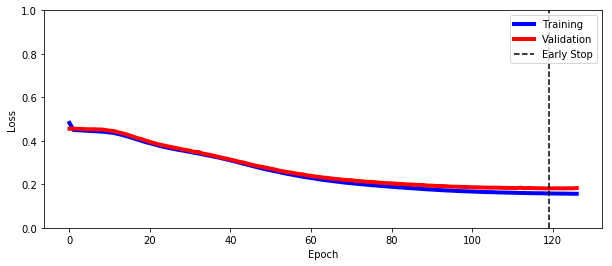

Test Set Performance:
Task 0: Loss: 0.1351	Balanced Accuracy: 90.17%	 auROC: 0.964	 auPRC: 0.927
	Recall at 5%|10%|20% FDR: 78.7%|83.5%|89.6%	 Num Positives: 701	 Num Negatives: 3299
Task 1: Loss: 0.0999	Balanced Accuracy: 93.20%	 auROC: 0.978	 auPRC: 0.949
	Recall at 5%|10%|20% FDR: 84.7%|90.8%|94.5%	 Num Positives: 655	 Num Negatives: 3345
Task 2: Loss: 0.2887	Balanced Accuracy: 75.89%	 auROC: 0.886	 auPRC: 0.666
	Recall at 5%|10%|20% FDR: 1.2%|6.1%|31.2%	 Num Positives: 672	 Num Negatives: 3328


In [76]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
multi_motif_default_model,multi_motif_default_history=train_default_model(multi_motif_data,3)

### Heterodimer Motif Grammar 

In this binary simulation task, we simulate 20K 500 bp random sequences with one instance of an SPI1 motif and one instance of an IRF motif. In the positive set of 10K sequences, the pair of motifs are embedded with a relative spacing of 2-5 bp between each other, at any random position in each sequence. In the negative set, the pair of motifs are both randomly embedded with no positional or spacing constraints. 

In [59]:
print_simulation_info("simulate_heterodimer_grammar")


    Simulates two classes of sequences with motif1 and motif2:
        - Positive class sequences with motif1 and motif2 positioned
          min_spacing and max_spacing
        - Negative class sequences with independent motif1 and motif2 positioned
        anywhere in the sequence, not as a heterodimer grammar

    Parameters
    ----------
    seq_length : int, length of sequence
    GC_fraction : float, GC fraction in background sequence
    num_pos : int, number of positive class sequences
    num_neg : int, number of negatice class sequences
    motif1 : str, encode motif name
    motif2 : str, encode motif name
    min_spacing : int, minimum inter motif spacing
    max_spacing : int, maximum inter motif spacing

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: list
        List of embedding objects.
    


In [78]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

To solve this simulation, the model needs to detect both motifs and learn the spacing constraint between them in the positive set. For this simulation, an architecture with a single convolutional layer does not perform well. Hence, we use a reference architecture with 3 convolutional layers. Each convolutional layer has 15 filters (size 15, stride 1) and ReLU-non-linearity, followed by max-pooling (size 35, stride 35), followed by a fully connected layer with sigmoid non-linearity for binary classification.

Training Data:
Loss: 0.6907	Balanced Accuracy: 54.50%	 auROC: 0.568	 auPRC: 0.564
	Recall at 5%|10%|20% FDR: 0.1%|0.2%|0.2%	 Num Positives: 6412	 Num Negatives: 6388
Validation Data:
Loss: 0.6931	Balanced Accuracy: 51.61%	 auROC: 0.511	 auPRC: 0.505
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1603	 Num Negatives: 1597
Training Data:
Loss: 0.6868	Balanced Accuracy: 58.00%	 auROC: 0.628	 auPRC: 0.616
	Recall at 5%|10%|20% FDR: 0.2%|0.3%|1.1%	 Num Positives: 6412	 Num Negatives: 6388
Validation Data:
Loss: 0.6933	Balanced Accuracy: 50.13%	 auROC: 0.511	 auPRC: 0.506
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1603	 Num Negatives: 1597
Training Data:
Loss: 0.6815	Balanced Accuracy: 60.54%	 auROC: 0.667	 auPRC: 0.656
	Recall at 5%|10%|20% FDR: 0.9%|1.2%|5.2%	 Num Positives: 6412	 Num Negatives: 6388
Validation Data:
Loss: 0.6934	Balanced Accuracy: 50.54%	 auROC: 0.514	 auPRC: 0.509
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1603	 Num Negatives: 159

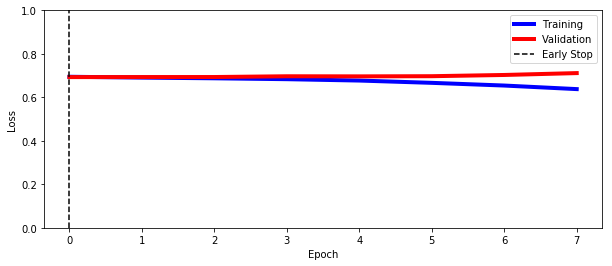

Test Set Performance:
Loss: 0.7224	Balanced Accuracy: 48.92%	 auROC: 0.485	 auPRC: 0.486
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1985	 Num Negatives: 2015


In [93]:
def build_heterodimer_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))    
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model


#Train default model 
heterodimer_default_model,heterodimer_default_history=train_default_model(heterodimer_data,1,build_heterodimer_model)

## Hyperparameter Grid Search

We now systematically vary the number of training examples, size of convolutional filters, number of convolutional filters and size of max pooling to understand the impact of these hyperparameters on prediction performance for each of the simulations.

DragoNN provides several helper functions to perform the hyperparameter grid search 

In [97]:
from dragonn.hyperparameter_search_tutorial import * 

test_auPRC=dict() 
test_auPRC['SingleMotif_TAL1']=dict() 
test_auPRC['DensityDetection']=dict() 
test_auPRC['DensityLocalization']=dict() 
test_auPRC['MultipleMotifDetection']=dict() 
test_auPRC['HeterodimerGrammar']=dict() 

### Training examples


In [ ]:
num_training_examples=range(500,13000,500)
for val in num_training_examples: 
   test_auPRC['SingleMotif_TAL1']['']
    
    

### Convolutional Filter Width


### Number of convolution filters


### Max Pooling Width